# Mixed States Reconstruction (Infidelity as loss)

In [1]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.linalg
import qiskit as qk
import qiskit.visualization

from qiskit import Aer
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector

from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit import transpile
from qiskit.quantum_info.operators import Operator

import tensorflow as tf
from tensorflow.python.framework.ops import convert_to_tensor
print("TensorFlow version:", tf.__version__)

import keras
from keras.layers import Dense, Input, Lambda, concatenate
from tensorflow.keras import Model

TensorFlow version: 2.11.0


In [2]:
#ensure reproducibility
np.random.seed(123)
tf.random.set_seed(123)
import random
random.seed(10)

tf.debugging.set_log_device_placement(False)

## Data Generation (Haar Distribution)

In [3]:
# generation of a random unitary transformation
def random_unitary(N):
    Z=np.random.randn(N,N) + 1.0j * np.random.randn(N,N)
    [Q,R]=sp.linalg.qr(Z)
    D=np.diag(np.diagonal(R)/np.abs(np.diagonal(R)))
    return np.dot(Q,D)

In [4]:
#Choice of the simulator
sim_bknd=Aer.get_backend('aer_simulator')

In [5]:
def generate_Haar_data(num_qubits, samples):
    data = []
    for i in range(samples):
        qc = qk.QuantumCircuit(num_qubits) #creates a quantum circuit with "num_qubits" qubits
        u = random_unitary(2**num_qubits)
        qc.unitary(u, qubits=range(num_qubits)) #applies the random unitary transformation to the circuit
        qc = qk.transpile(qc, backend=sim_bknd) #to optimize the circuit
        qc.save_statevector() #saves the state vector obtained by the simulation

        state = sim_bknd.run(qc).result().get_statevector(qc) #does the simulation and gets the state vector
        state = np.asarray(state)
        data.append(state) 
    return data

In [6]:
#obtaining mixed states from pure ones
def mixed_states(bloch_vectors):
   for i in range(len(bloch_vectors)):
      bloch_vectors[i] = np.random.rand()**(1/3)* bloch_vectors[i]
   return bloch_vectors 

## (In)Fidelity Implementation

In [7]:
#define pauli basis
I_tf = tf.constant([1.0, 0.0,0.0,1.0],shape=(2,2), dtype = tf.complex64)
X_tf = tf.constant([0.0, 1.0, 1.0, 0.0],shape=(2,2), dtype = tf.complex64)
Y_tf = tf.constant([0.0+0j, 0.0-1j ,0.0+1j,0.0+0j],shape=(2,2), dtype = tf.complex64)
Z_tf = tf.constant([1.0, 0.0,0.0,-1.0],shape=(2,2), dtype = tf.complex64)

In [8]:
#define pauli group without identity
A = tf.stack([X_tf,Y_tf,Z_tf])

In [9]:
#define loss function
@tf.function
def infidelity(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',A,a) 
   el_b = tf.einsum('ijk,mi->mjk',A,b) 
   rho_a = 0.5 *(el_a + I_tf)
   rho_b = 0.5 * (el_b +I_tf)
   fidelity = tf.linalg.trace(tf.linalg.sqrtm(tf.linalg.sqrtm(rho_a) @ rho_b @ tf.linalg.sqrtm(rho_a))) **2
   infidelity = (1 - fidelity) 
   return infidelity

In [10]:
#define loss function
@tf.function
def inf(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',A,a) 
   el_b = tf.einsum('ijk,mi->mjk',A,b) 
   rho_a = 0.5 *(el_a + I_tf)
   rho_b = 0.5 * (el_b +I_tf)


   numer = tf.math.abs(tf.linalg.trace(tf.matmul(rho_a, rho_b)))
   den = tf.math.sqrt(tf.linalg.trace(tf.linalg.matmul(rho_a, rho_a)) * tf.linalg.trace(tf.linalg.matmul(rho_b, rho_b)))
   numer = tf.cast(numer, tf.complex64)
   infidelity = 1 - numer/den
   return infidelity

In [11]:
print(tf.math.abs(tf.linalg.trace(tf.matmul(Y_tf, Y_tf))))
print(tf.linalg.matmul(Y_tf, Y_tf))

tf.Tensor(2.0, shape=(), dtype=float32)
tf.Tensor(
[[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]], shape=(2, 2), dtype=complex64)


In [12]:
def fidelity_function(a,b):
  fid=np.trace(sp.linalg.sqrtm(sp.linalg.sqrtm(a) @ b @ sp.linalg.sqrtm(a))) ** 2
  return fid

## Noise Model

In [13]:
#single element of the operator sum representation
def sum_element(rho,operator):
    element = np.dot(np.dot(operator,rho),operator.conj().T)
    return element

In [14]:
#define phase flip channel

def phase_flip_error(rho, p):

    E_0 = np.sqrt(1-p)*I
    E_1 = np.sqrt(p)*Z
    
    rho_with_flip_error = sum_element(rho, E_0)+sum_element(rho, E_1)
    
    return rho_with_flip_error

## Useful Quantum Functions

In [15]:
#getting the density matrix given the state vector
def get_density_matrix(state_vector):
    density_matrix = np.outer(state_vector, np.conjugate(state_vector))
    return density_matrix

In [16]:
#pauli basis in numpy
I = np.array([[1, 0],[0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

#get bloch vector from density matrix
def Bloch_vector(rho):
    ax = np.trace(np.dot(rho, X)).real
    ay = np.trace(np.dot(rho, Y)).real
    az = np.trace(np.dot(rho, Z)).real
    pnt = [ax, ay, az]
    return np.array(pnt)

In [17]:
#represent data on Bloch sphere
def Bloch_sphere(data):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(projection='3d')
    qk.visualization.plot_bloch_vector([0, 0, 0], title='Bloch Sphere',ax=ax)
    for (x, y, z) in data:
        ax.scatter3D(y, -x, z, c='b') #here x and y axis are inverted in order to match qiskit and matplotlib axis

In [18]:
def rho_from_vec(vector):
  el = X*vector[0]+Y*vector[1]+Z*vector[2]
  rho = 0.5 *(el + I_tf)
  return rho

## Testing the Algorithm

In [19]:
#GENERATE DATA
data = generate_Haar_data(1, 1000)

pure_density_matrix_noise_free = [*map(get_density_matrix, data)] #pure haar distributed states obtained
pure_vectors_noise_free = [*map(Bloch_vector, pure_density_matrix_noise_free)]
bloch_vectors_noise_free = mixed_states(pure_vectors_noise_free) #transform pure states in mixed ones

#COMPUTE DENSITY MATRIX
density_matrix_noise_free = [*map(rho_from_vec, bloch_vectors_noise_free)]

In [20]:
#VISUALIZE DATA ON BLOCH SPHERE
#Bloch_sphere(bloch_vectors_noise_free)

In [21]:
#APPLY NOISE (in this case phase channel with p=0.2)
density_matrix_with_noise = []
for i in range(len(data)):
    single_data_with_noise = phase_flip_error(density_matrix_noise_free[i], 0.2)
    density_matrix_with_noise.append(single_data_with_noise)

In [22]:
#COMPUTE_BLOCH VECTOR WITH NOISE
bloch_vectors_with_noise = [*map(Bloch_vector, density_matrix_with_noise)]

In [23]:
#VISUALIZE NOISY DATA ON BLOCH SPHERE
#Bloch_sphere(bloch_vectors_with_noise)

In [24]:
#Building the Dataset
x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:50], bloch_vectors_with_noise[600:800], bloch_vectors_with_noise[800:]
y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:50], bloch_vectors_noise_free[600:800], bloch_vectors_noise_free[800:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [25]:
#compute the norms
norms_train = tf.norm(y_train, axis=1)
norms_val = tf.norm(y_val, axis=1)
norms_test = tf.norm(y_test, axis=1)

In [26]:
@tf.function
def custom_layer(input):
  a = tf.gather(input, [0,1,2], axis=1)
  b = tf.gather(input, [3], axis=1)
  output = a *b
  return output

In [35]:
input_layer1 = Input(shape=(3,))
input_layer2 = Input(shape=(1,))

#first branch
x = Dense(64, activation='relu')(input_layer1)
x = Dense(64, activation='relu')(x)
#x = Dense(16, activation='relu')(x)
dense_1 = Dense(units='3', name='vector')(x) 
normal = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(dense_1)
model_1 = Model(inputs = input_layer1, outputs = normal) #normal


#combine the outputs 
combined = concatenate([model_1.output, input_layer2])

#last passage: normalization 
z = Lambda(custom_layer)(combined)


model = Model(inputs=[input_layer1, input_layer2], outputs=z)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 64)           256         ['input_3[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 64)           4160        ['dense_3[0][0]']                
                                                                                                  
 vector (Dense)                 (None, 3)            195         ['dense_4[0][0]']                
                                                                                            

In [36]:
# Define Loss
adam_opt = tf.optimizers.Adam(0.001)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=inf)

history = model.fit([x_train, norms_train], y_train, validation_data=([x_val, norms_val], y_val), batch_size=10, epochs=1000)

Epoch 1/1000
5/5 [==============================] - 2s 94ms/step - loss: 0.2288 - val_loss: 0.2343
Epoch 2/1000
5/5 [==============================] - 0s 30ms/step - loss: 0.1579 - val_loss: 0.1720
Epoch 3/1000
5/5 [==============================] - 0s 30ms/step - loss: 0.0993 - val_loss: 0.1108
Epoch 4/1000
5/5 [==============================] - 0s 39ms/step - loss: 0.0616 - val_loss: 0.0674
Epoch 5/1000
5/5 [==============================] - 0s 36ms/step - loss: 0.0336 - val_loss: 0.0434
Epoch 6/1000
5/5 [==============================] - 0s 34ms/step - loss: 0.0225 - val_loss: 0.0314
Epoch 7/1000
5/5 [==============================] - 0s 36ms/step - loss: 0.0158 - val_loss: 0.0230
Epoch 8/1000
5/5 [==============================] - 0s 36ms/step - loss: 0.0110 - val_loss: 0.0176
Epoch 9/1000
5/5 [==============================] - 0s 39ms/step - loss: 0.0076 - val_loss: 0.0137
Epoch 10/1000
5/5 [==============================] - 0s 32ms/step - loss: 0.0057 - val_loss: 0.0106
Epoch 11/

5/5 [==============================] - 0s 32ms/step - loss: 2.5493e-05 - val_loss: 0.0012
Epoch 81/1000
5/5 [==============================] - 0s 32ms/step - loss: 2.4107e-05 - val_loss: 0.0012
Epoch 82/1000
5/5 [==============================] - 0s 36ms/step - loss: 2.2974e-05 - val_loss: 0.0012
Epoch 83/1000
5/5 [==============================] - 0s 35ms/step - loss: 2.1129e-05 - val_loss: 0.0012
Epoch 84/1000
5/5 [==============================] - 0s 37ms/step - loss: 2.1539e-05 - val_loss: 0.0012
Epoch 85/1000
5/5 [==============================] - 0s 40ms/step - loss: 2.0534e-05 - val_loss: 0.0012
Epoch 86/1000
5/5 [==============================] - 0s 44ms/step - loss: 2.0497e-05 - val_loss: 0.0012
Epoch 87/1000
5/5 [==============================] - 0s 31ms/step - loss: 1.9255e-05 - val_loss: 0.0012
Epoch 88/1000
5/5 [==============================] - 0s 28ms/step - loss: 2.0177e-05 - val_loss: 0.0012
Epoch 89/1000
5/5 [==============================] - 0s 30ms/step - loss: 1.91

5/5 [==============================] - 0s 36ms/step - loss: 4.1974e-06 - val_loss: 0.0012
Epoch 159/1000
5/5 [==============================] - 0s 32ms/step - loss: 3.9375e-06 - val_loss: 0.0012
Epoch 160/1000
5/5 [==============================] - 0s 31ms/step - loss: 3.7885e-06 - val_loss: 0.0012
Epoch 161/1000
5/5 [==============================] - 0s 33ms/step - loss: 3.8362e-06 - val_loss: 0.0012
Epoch 162/1000
5/5 [==============================] - 0s 34ms/step - loss: 3.7622e-06 - val_loss: 0.0012
Epoch 163/1000
5/5 [==============================] - 0s 32ms/step - loss: 3.7134e-06 - val_loss: 0.0012
Epoch 164/1000
5/5 [==============================] - 0s 36ms/step - loss: 3.7515e-06 - val_loss: 0.0012
Epoch 165/1000
5/5 [==============================] - 0s 32ms/step - loss: 3.7217e-06 - val_loss: 0.0012
Epoch 166/1000
5/5 [==============================] - 0s 36ms/step - loss: 3.8576e-06 - val_loss: 0.0012
Epoch 167/1000
5/5 [==============================] - 0s 35ms/step - l

5/5 [==============================] - 0s 36ms/step - loss: 1.1253e-06 - val_loss: 0.0012
Epoch 237/1000
5/5 [==============================] - 0s 33ms/step - loss: 1.2684e-06 - val_loss: 0.0012
Epoch 238/1000
5/5 [==============================] - 0s 28ms/step - loss: 1.1611e-06 - val_loss: 0.0012
Epoch 239/1000
5/5 [==============================] - 0s 34ms/step - loss: 1.1826e-06 - val_loss: 0.0012
Epoch 240/1000
5/5 [==============================] - 0s 34ms/step - loss: 1.0657e-06 - val_loss: 0.0012
Epoch 241/1000
5/5 [==============================] - 0s 34ms/step - loss: 1.0788e-06 - val_loss: 0.0012
Epoch 242/1000
5/5 [==============================] - 0s 41ms/step - loss: 1.1039e-06 - val_loss: 0.0012
Epoch 243/1000
5/5 [==============================] - 0s 36ms/step - loss: 1.2553e-06 - val_loss: 0.0012
Epoch 244/1000
5/5 [==============================] - 0s 29ms/step - loss: 1.0598e-06 - val_loss: 0.0012
Epoch 245/1000
5/5 [==============================] - 0s 34ms/step - l

5/5 [==============================] - 0s 31ms/step - loss: 4.2319e-07 - val_loss: 0.0012
Epoch 315/1000
5/5 [==============================] - 0s 31ms/step - loss: 4.3631e-07 - val_loss: 0.0012
Epoch 316/1000
5/5 [==============================] - 0s 30ms/step - loss: 6.8903e-07 - val_loss: 0.0012
Epoch 317/1000
5/5 [==============================] - 0s 34ms/step - loss: 4.7922e-07 - val_loss: 0.0012
Epoch 318/1000
5/5 [==============================] - 0s 35ms/step - loss: 4.3154e-07 - val_loss: 0.0012
Epoch 319/1000
5/5 [==============================] - 0s 31ms/step - loss: 4.6134e-07 - val_loss: 0.0012
Epoch 320/1000
5/5 [==============================] - 0s 29ms/step - loss: 4.7088e-07 - val_loss: 0.0012
Epoch 321/1000
5/5 [==============================] - 0s 32ms/step - loss: 4.6253e-07 - val_loss: 0.0012
Epoch 322/1000
5/5 [==============================] - 0s 37ms/step - loss: 4.0889e-07 - val_loss: 0.0012
Epoch 323/1000
5/5 [==============================] - 0s 36ms/step - l

5/5 [==============================] - 0s 32ms/step - loss: 5.1737e-07 - val_loss: 0.0012
Epoch 393/1000
5/5 [==============================] - 0s 36ms/step - loss: 6.5446e-07 - val_loss: 0.0012
Epoch 394/1000
5/5 [==============================] - 0s 34ms/step - loss: 6.8307e-07 - val_loss: 0.0012
Epoch 395/1000
5/5 [==============================] - 0s 34ms/step - loss: 7.6771e-07 - val_loss: 0.0012
Epoch 396/1000
5/5 [==============================] - 0s 35ms/step - loss: 8.9526e-07 - val_loss: 0.0012
Epoch 397/1000
5/5 [==============================] - 0s 36ms/step - loss: 1.7202e-06 - val_loss: 0.0012
Epoch 398/1000
5/5 [==============================] - 0s 34ms/step - loss: 2.4068e-06 - val_loss: 0.0012
Epoch 399/1000
5/5 [==============================] - 0s 38ms/step - loss: 1.7810e-06 - val_loss: 0.0013
Epoch 400/1000
5/5 [==============================] - 0s 36ms/step - loss: 2.6846e-06 - val_loss: 0.0012
Epoch 401/1000
5/5 [==============================] - 0s 30ms/step - l

5/5 [==============================] - 0s 32ms/step - loss: 2.0232e-05 - val_loss: 0.0013
Epoch 471/1000
5/5 [==============================] - 0s 34ms/step - loss: 2.1052e-05 - val_loss: 0.0011
Epoch 472/1000
5/5 [==============================] - 0s 30ms/step - loss: 1.8960e-05 - val_loss: 0.0012
Epoch 473/1000
5/5 [==============================] - 0s 30ms/step - loss: 2.2891e-05 - val_loss: 0.0013
Epoch 474/1000
5/5 [==============================] - 0s 30ms/step - loss: 2.3934e-05 - val_loss: 0.0011
Epoch 475/1000
5/5 [==============================] - 0s 41ms/step - loss: 3.2551e-05 - val_loss: 0.0013
Epoch 476/1000
5/5 [==============================] - 0s 34ms/step - loss: 2.7484e-05 - val_loss: 0.0012
Epoch 477/1000
5/5 [==============================] - 0s 30ms/step - loss: 3.2619e-05 - val_loss: 0.0012
Epoch 478/1000
5/5 [==============================] - 0s 33ms/step - loss: 4.0380e-05 - val_loss: 0.0012
Epoch 479/1000
5/5 [==============================] - 0s 36ms/step - l

5/5 [==============================] - 0s 36ms/step - loss: 3.3140e-07 - val_loss: 9.1932e-04
Epoch 547/1000
5/5 [==============================] - 0s 34ms/step - loss: 3.5524e-07 - val_loss: 9.0920e-04
Epoch 548/1000
5/5 [==============================] - 0s 33ms/step - loss: 3.4213e-07 - val_loss: 9.1812e-04
Epoch 549/1000
5/5 [==============================] - 0s 36ms/step - loss: 3.8147e-07 - val_loss: 9.0943e-04
Epoch 550/1000
5/5 [==============================] - 0s 35ms/step - loss: 3.2306e-07 - val_loss: 9.2351e-04
Epoch 551/1000
5/5 [==============================] - 0s 32ms/step - loss: 2.7657e-07 - val_loss: 9.0955e-04
Epoch 552/1000
5/5 [==============================] - 0s 30ms/step - loss: 2.4796e-07 - val_loss: 9.2163e-04
Epoch 553/1000
5/5 [==============================] - 0s 34ms/step - loss: 2.9445e-07 - val_loss: 9.1329e-04
Epoch 554/1000
5/5 [==============================] - 0s 34ms/step - loss: 2.8491e-07 - val_loss: 9.1532e-04
Epoch 555/1000
5/5 [==============

5/5 [==============================] - 0s 34ms/step - loss: 1.9908e-07 - val_loss: 9.1291e-04
Epoch 622/1000
5/5 [==============================] - 0s 32ms/step - loss: 1.2398e-07 - val_loss: 9.1437e-04
Epoch 623/1000
5/5 [==============================] - 0s 30ms/step - loss: 1.0252e-07 - val_loss: 9.1437e-04
Epoch 624/1000
5/5 [==============================] - 0s 31ms/step - loss: 9.6560e-08 - val_loss: 9.1127e-04
Epoch 625/1000
5/5 [==============================] - 0s 34ms/step - loss: 1.1683e-07 - val_loss: 9.1976e-04
Epoch 626/1000
5/5 [==============================] - 0s 34ms/step - loss: 2.1696e-07 - val_loss: 9.0975e-04
Epoch 627/1000
5/5 [==============================] - 0s 32ms/step - loss: 1.9908e-07 - val_loss: 9.2318e-04
Epoch 628/1000
5/5 [==============================] - 0s 30ms/step - loss: 2.4796e-07 - val_loss: 9.0265e-04
Epoch 629/1000
5/5 [==============================] - 0s 32ms/step - loss: 3.9935e-07 - val_loss: 9.1814e-04
Epoch 630/1000
5/5 [==============

5/5 [==============================] - 0s 34ms/step - loss: 2.8672e-05 - val_loss: 8.3198e-04
Epoch 697/1000
5/5 [==============================] - 0s 40ms/step - loss: 2.5631e-05 - val_loss: 9.0638e-04
Epoch 698/1000
5/5 [==============================] - 0s 37ms/step - loss: 3.8873e-05 - val_loss: 0.0011
Epoch 699/1000
5/5 [==============================] - 0s 36ms/step - loss: 5.3325e-05 - val_loss: 8.8873e-04
Epoch 700/1000
5/5 [==============================] - 0s 40ms/step - loss: 4.6285e-05 - val_loss: 8.8953e-04
Epoch 701/1000
5/5 [==============================] - 0s 35ms/step - loss: 5.9590e-05 - val_loss: 0.0012
Epoch 702/1000
5/5 [==============================] - 0s 34ms/step - loss: 6.3713e-05 - val_loss: 7.6572e-04
Epoch 703/1000
5/5 [==============================] - 0s 32ms/step - loss: 1.3630e-04 - val_loss: 0.0012
Epoch 704/1000
5/5 [==============================] - 0s 32ms/step - loss: 9.2947e-05 - val_loss: 8.1503e-04
Epoch 705/1000
5/5 [==========================

Epoch 772/1000
5/5 [==============================] - 0s 34ms/step - loss: 3.9697e-07 - val_loss: 7.0532e-04
Epoch 773/1000
5/5 [==============================] - 0s 39ms/step - loss: 4.4227e-07 - val_loss: 6.9164e-04
Epoch 774/1000
5/5 [==============================] - 0s 40ms/step - loss: 3.5524e-07 - val_loss: 7.0600e-04
Epoch 775/1000
5/5 [==============================] - 0s 39ms/step - loss: 4.5657e-07 - val_loss: 6.9595e-04
Epoch 776/1000
5/5 [==============================] - 0s 38ms/step - loss: 6.3300e-07 - val_loss: 7.0347e-04
Epoch 777/1000
5/5 [==============================] - 0s 37ms/step - loss: 5.7697e-07 - val_loss: 6.9933e-04
Epoch 778/1000
5/5 [==============================] - 0s 40ms/step - loss: 5.0068e-07 - val_loss: 7.0747e-04
Epoch 779/1000
5/5 [==============================] - 0s 29ms/step - loss: 2.8729e-07 - val_loss: 6.9800e-04
Epoch 780/1000
5/5 [==============================] - 0s 30ms/step - loss: 2.9087e-07 - val_loss: 7.0652e-04
Epoch 781/1000
5/5 

5/5 [==============================] - 0s 40ms/step - loss: 1.1921e-07 - val_loss: 7.0061e-04
Epoch 848/1000
5/5 [==============================] - 0s 38ms/step - loss: 1.5974e-07 - val_loss: 6.9728e-04
Epoch 849/1000
5/5 [==============================] - 0s 38ms/step - loss: 1.4186e-07 - val_loss: 6.9105e-04
Epoch 850/1000
5/5 [==============================] - 0s 39ms/step - loss: 2.2650e-07 - val_loss: 7.0113e-04
Epoch 851/1000
5/5 [==============================] - 0s 38ms/step - loss: 2.3127e-07 - val_loss: 6.9577e-04
Epoch 852/1000
5/5 [==============================] - 0s 38ms/step - loss: 1.9312e-07 - val_loss: 7.0596e-04
Epoch 853/1000
5/5 [==============================] - 0s 39ms/step - loss: 3.7909e-07 - val_loss: 6.8959e-04
Epoch 854/1000
5/5 [==============================] - 0s 32ms/step - loss: 6.1035e-07 - val_loss: 7.0838e-04
Epoch 855/1000
5/5 [==============================] - 0s 30ms/step - loss: 4.9710e-07 - val_loss: 6.9015e-04
Epoch 856/1000
5/5 [==============

5/5 [==============================] - 0s 31ms/step - loss: 7.0131e-05 - val_loss: 7.1755e-04
Epoch 923/1000
5/5 [==============================] - 0s 28ms/step - loss: 6.1718e-05 - val_loss: 7.0972e-04
Epoch 924/1000
5/5 [==============================] - 0s 32ms/step - loss: 5.0746e-05 - val_loss: 5.8580e-04
Epoch 925/1000
5/5 [==============================] - 0s 28ms/step - loss: 6.8665e-05 - val_loss: 9.4789e-04
Epoch 926/1000
5/5 [==============================] - 0s 31ms/step - loss: 5.7045e-05 - val_loss: 6.8307e-04
Epoch 927/1000
5/5 [==============================] - 0s 40ms/step - loss: 4.1888e-05 - val_loss: 7.2195e-04
Epoch 928/1000
5/5 [==============================] - 0s 35ms/step - loss: 3.9257e-05 - val_loss: 6.5893e-04
Epoch 929/1000
5/5 [==============================] - 0s 32ms/step - loss: 2.6828e-05 - val_loss: 6.0548e-04
Epoch 930/1000
5/5 [==============================] - 0s 31ms/step - loss: 2.1329e-05 - val_loss: 7.5341e-04
Epoch 931/1000
5/5 [==============

5/5 [==============================] - 0s 33ms/step - loss: 2.0692e-05 - val_loss: 6.7582e-04
Epoch 998/1000
5/5 [==============================] - 0s 31ms/step - loss: 2.6625e-05 - val_loss: 5.1377e-04
Epoch 999/1000
5/5 [==============================] - 0s 30ms/step - loss: 4.2220e-05 - val_loss: 6.2350e-04
Epoch 1000/1000
5/5 [==============================] - 0s 30ms/step - loss: 4.5265e-05 - val_loss: 6.3309e-04


In [37]:
score = model.evaluate([x_test, norms_test], y_test, verbose=2)

7/7 - 0s - loss: 5.4014e-04 - 330ms/epoch - 47ms/step


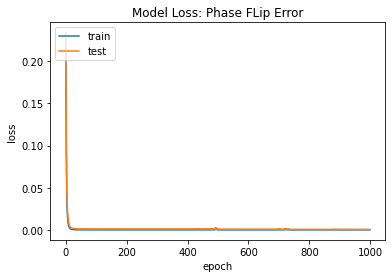

In [38]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Phase FLip Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [39]:
#save the model predictions in a tensor
y_prediction = model([x_test, norms_test])
y_prediction = tf.cast(y_prediction, tf.complex64)
y_test = tf.cast(y_test, tf.complex64)


fidelities = []
for i in range(len(y_prediction)):
  den_mat = rho_from_vec(y_prediction[i])
  den_mat = np.asarray(den_mat)

  den_mat_id = rho_from_vec(y_test[i])
  den_mat_id = np.asarray(den_mat_id)

  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)



print(tf.math.reduce_mean(fidelities))

tf.Tensor((0.9995417971816712-1.7906394129916755e-09j), shape=(), dtype=complex128)


(0.9999738461574346-2.979579529381215e-08j)
tf.Tensor([-0.04015727+0.j -0.01475626+0.j -0.08816586+0.j], shape=(3,), dtype=complex64)
tf.Tensor([-0.03471306+0.j -0.02344652+0.j -0.08859368+0.j], shape=(3,), dtype=complex64)


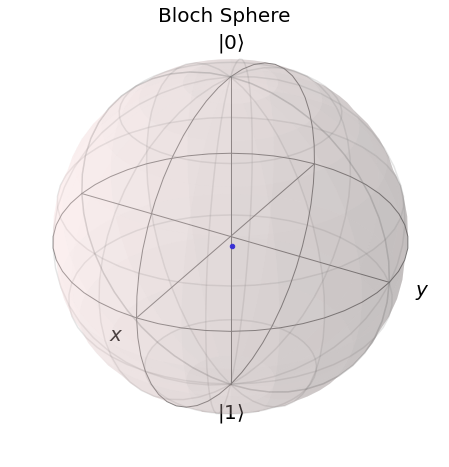

In [40]:
den_mat = rho_from_vec(y_prediction[0])
den_mat = np.asarray(den_mat)

den_mat_id = rho_from_vec(y_test[0])
den_mat_id = np.asarray(den_mat_id)

print(fidelity_function(den_mat_id, den_mat))


print(y_prediction[0])
print(y_test[0])

Bloch_sphere(y_prediction[:1])

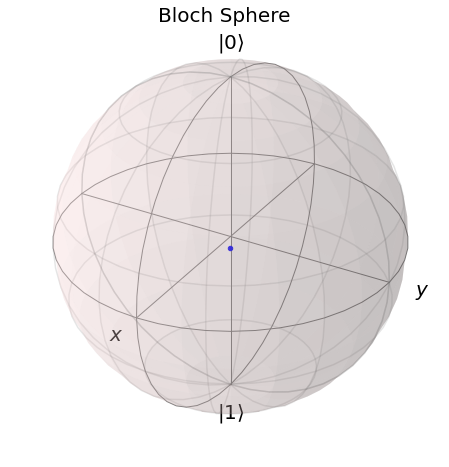

In [33]:
Bloch_sphere(x_test[:1])

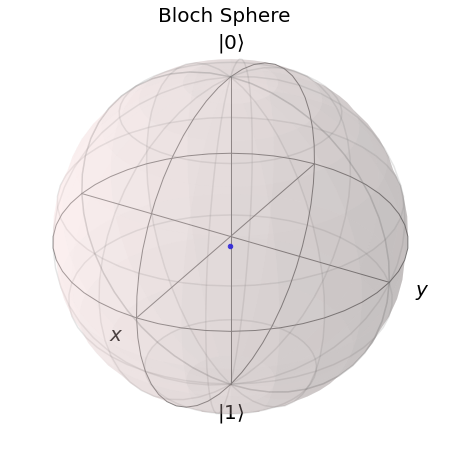

In [34]:
Bloch_sphere(y_test[:1])